In [1]:
"""
This file is the entry point for the project
"""
# Begin by importing external libraries using path_setup
# NOTE : Must be ran first, thus PEP8-E402
import path_setup
path_setup.path_setup()
import sys  # noqa E402
import matplotlib.pyplot as plt # noqa E402
import numpy as np # noqa E402
import datetime as dt # noqa E402
from LatticeClass_F import lattice_class as lt # noqa E402
import PrintException as PE  # noqa E402
import input_funcs as inF  # noqa E402
from random import random  # noqa E402
# Shebang line for interactive output in vs_code, comment this out if you have troubles running the notebook\n",
# %matplotlib widget

def plot_metrop(SE_mtx, BJ, size):
    fig, axes = plt.subplots(
        1, 2, figsize=(12, 4),
        num=f'Evolution of Average Spin and Energy for BJ={BJ}')
    ax = axes[0]
    ax.plot(SE_mtx[:, 0] / (size[0]*size[1]))
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(r'Average Spin $\bar{m}$')
    ax.grid()
    ax = axes[1]
    ax.plot(SE_mtx[:, 1])
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(r'Energy $E/J$')
    ax.grid()
    fig.tight_layout()
    plt.show()

def rand_time() -> int:
    out = int(dt.datetime.now().strftime('%s'))
    sys.stdout.write(f"Time Seed = {out}\n")
    return(int(dt.datetime.now().strftime('%s')))

In [2]:
N = 20
M = 9
size = [N, M]
lt_a = lt(1, size)
lt_b = lt(1, size, [[1, 0], [0.5, np.sqrt(3)/2]])
lt_c = lt(1, size, [[0.5, np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]])
lt_d = lt(1, size, [[0.128, np.e], [3.02398, -np.e]])

output = input('Enter 0 for seeded random or 1 for time based:')

if output == '0':
    # DOCtest seed = 1644121893
    seed = 1644121893
    lt_a.randomize(0.5, seed, quiet=False)
    lt_b.randomize(0.25, seed)
    lt_c.randomize(0.27, seed)
    lt_d.randomize(0.27, seed)

else:
    lt_a.randomize(random(), rand_time(), False)
    lt_b.randomize(random(), rand_time(), False)
    lt_c.randomize(random(), rand_time(), False)
    lt_d.randomize(random(), rand_time(), False)

/home/kirisame_ramen/Programs/active projects/fall_2021_project_physics/src/linked_list_class.py:430: RuntimeWarning: invalid value encountered in true_divide
  temp = np.arccos((possible_neighbor-origin).dot(origin) /



Generation complete!

Generation complete!

Generation complete!
Time Seed = 1644139194
Generating Seed = 1644139194
Time Seed = 1644139194
Generating Seed = 1644139194
Time Seed = 1644139194
Generating Seed = 1644139194
Time Seed = 1644139194
Generating Seed = 1644139194


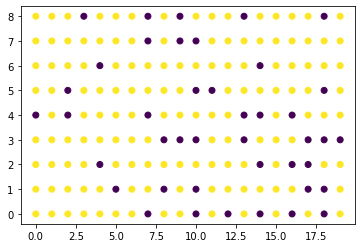

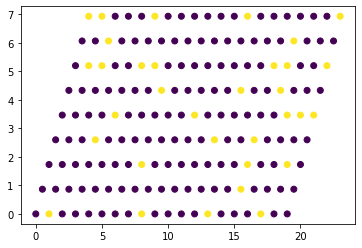

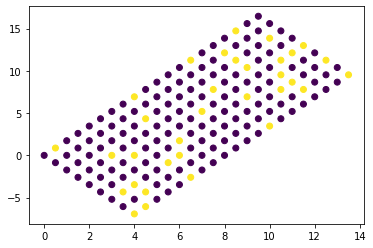

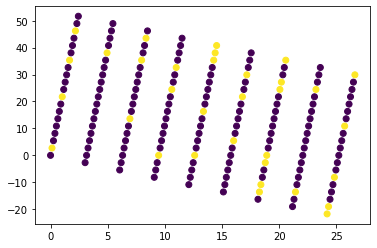

In [3]:
lt_a.display()
lt_b.display()
lt_c.display()
lt_d.display()

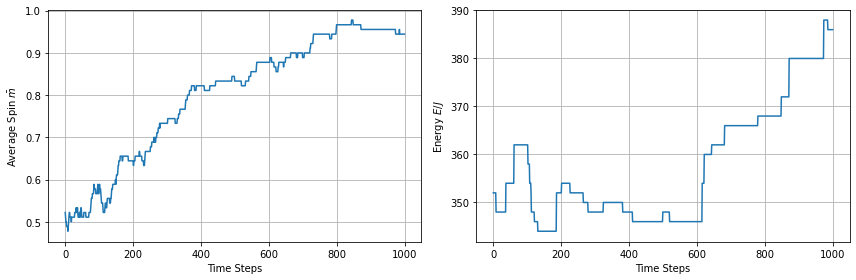

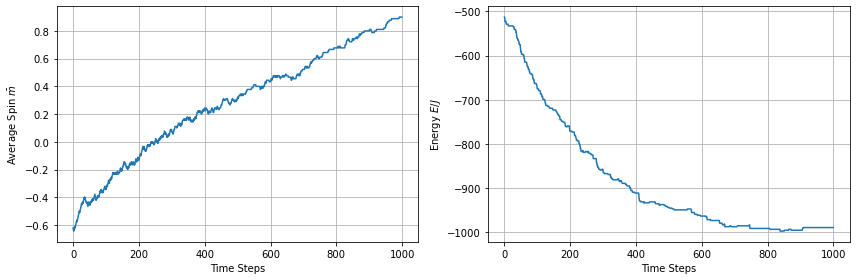

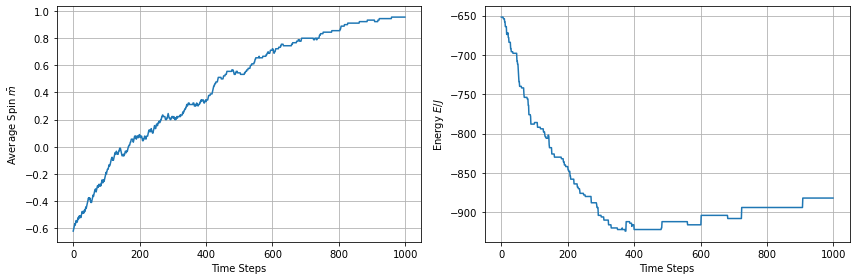

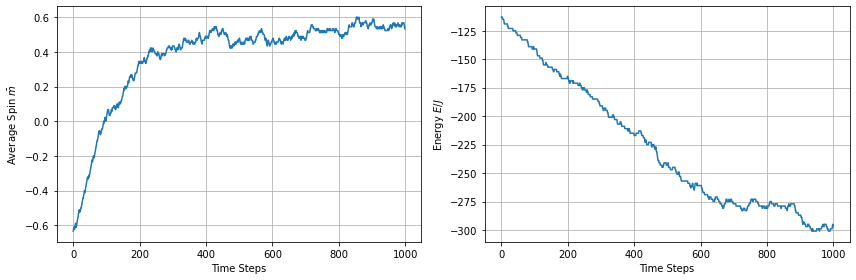

In [4]:
total_time = 1000
BJ = 1
SE_mtx = lt_a.metropolis(total_time, BJ)
plot_metrop(SE_mtx, BJ, size)
SE_mtx = lt_b.metropolis(total_time, BJ)
plot_metrop(SE_mtx, BJ, size)
SE_mtx = lt_c.metropolis(total_time, BJ)
plot_metrop(SE_mtx, BJ, size)
SE_mtx = lt_d.metropolis(total_time, BJ)
plot_metrop(SE_mtx, BJ, size)